In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from PIL import ImageOps
from exp import *

In [2]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from torchvision.utils import save_image

In [3]:
model_path = Path('seg_data/train_images')

dm = DatasetManager('2017','224','all','2017')


In [4]:
train_images = dm.get_dataset_path('train_images')
valid_images = dm.get_dataset_path('valid_images')

In [5]:
assert len(train_images.ls()) == 2000
assert len(valid_images.ls()) == 150

In [6]:
learn = load_learner(model_path,file='segmenter_224.pkl')

In [7]:
def reload_dataset(dm,seed=1):
    random_seed(seed,True)
#     tfms = get_transforms(flip_vert=True, max_rotate=180,max_zoom=1.6, max_lighting=0.3,p_affine=1, max_warp=0)
    tfms = [[],[]]
    data = ImageList.from_folder(dm.get_dataset_path('train_images').parent)\
    .split_by_folder(train=dm.get_dataset_path('train_images').name,
                   valid=dm.get_dataset_path('valid_images').name)\
    .label_from_func(dm.get_label_for_image_path)\
    .transform(tfms,size=224)\
    .databunch(bs=16)\
    .normalize(imagenet_stats)
    return data

data = reload_dataset(dm)

### Utils

In [27]:
def tensor_to_gray(t): return t.mean(dim=0).expand(3,t.shape[1],t.shape[2])
def tensor_to_gray(t): return torch.tensor(.0).expand(3,t.shape[1],t.shape[2])

def invert_mask(m): return (m + 1) % 2 
def visualize_mask(m): visualize_tensor(m.expand(3,m.shape[1],m.shape[2]) * 255)
def visualize_tensor(t): plt.imshow(t.permute(1, 2, 0))
def mask_color(image_as_tensor,mask):
    coloured_part = (image_as_tensor * mask)
    gray_part = invert_mask(mask) * tensor_to_gray(image_as_tensor)
    return coloured_part+gray_part

### One image

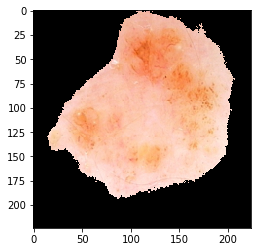

In [28]:
image = data.train_ds[2][0]
mask = learn.predict(image)[1]

def mask_color_keep_orig_size(image_as_tensor,mask_as_int_tensor):
    mask_as_float_tensor = (mask_as_int_tensor*1.0)
    return mask_color(image_as_tensor,mask_as_float_tensor)

masked_image = mask_color_keep_orig_size(image.data,mask)
visualize_tensor(masked_image)

In [29]:
def plot_masked_images(image_index):
    image = data.train_ds[image_index][0]
    mask = learn.predict(image)[1]
    masked_image = mask_color(image.data,mask)
    visualize_tensor(masked_image)

In [30]:
interact(plot_masked_images, image_index=widgets.FloatSlider(min=0, max=len(data.train_ds),step=1, continuous_update=False
))

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='image_index', max=2000.0, s…

<function __main__.plot_masked_images(image_index)>

In [31]:
p = data.train_ds.items[0]

In [32]:
Path(p.parent.as_posix() + '_segmented_absolute_gray')

PosixPath('2017_train_images_resized_to_224_picked_all_training_for_2017_segmented_absolute_gray')

In [33]:
def mask_image(image):
    mask = learn.predict(image)[1]
    masked_image = mask_color_keep_orig_size(image.data,mask)
    return masked_image

In [34]:
def mask_entire_dataset(dataset):
    for index in range(len(dataset)):
        image = dataset[index][0]
        masked_image = mask_image(image)


        #Get the correct path to save the masked image, we append _segmented to the directory
        original_image_path = dataset.items[index]
        original_image_name = original_image_path.name
        original_image_dir = original_image_path.parent

        new_image_dir = Path(original_image_dir.as_posix() + '_segmented_absolute_black')
        new_image_dir.mkdir(exist_ok=True)
        new_image_name = original_image_name
        new_image_path = new_image_dir / new_image_name

        save_image(masked_image, new_image_path)

In [35]:
mask_entire_dataset(data.valid_ds)

In [36]:
mask_entire_dataset(data.train_ds)